In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [0]:
import os
import random
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
from fastai.vision import *
from fastai.metrics import error_rate
from glob2 import glob
from sklearn.metrics import confusion_matrix
from google.colab import drive
from pathlib import Path

In [5]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
def split_indices(folder, seed1, seed2):
	n = len(os.listdir(folder))
	full_set = list(range(1, n + 1))

	random.seed(seed1)
	train = random.sample(list(range(1, n + 1)), int(0.5 * n))

	remain = list(set(full_set) - set(train))

	random.seed(seed2)
	valid = random.sample(remain, int(0.5 * len(remain)))
	test = list(set(remain) - set(valid))

	return (train, valid, test)

def get_names(waste_type, indices):
	file_names = [(waste_type + str(i) + ".jpg") for i in indices]
	return (file_names)

def move_files(source_files, destination_folder):
	for file in source_files:
		shutil.move(file, destination_folder)

subsets = ['train', 'valid']
waste_types = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

for subset in subsets:
	for waste_type in waste_types:
		folder = os.path.join('/content/drive/My Drive/data', subset, waste_type)
		if not os.path.exists(folder):
			os.makedirs(folder)

if not os.path.exists(os.path.join('data', 'test')):
	os.makedirs(os.path.join('data', 'test'))

for waste_type in waste_types:
	source_folder = os.path.join('/content/drive/My Drive/waste-data', waste_type)
	train_ind, valid_ind, test_ind = split_indices(source_folder, 1, 1)

	train_names = get_names(waste_type, train_ind)
	train_source_files = [os.path.join(source_folder, name) for name in train_names]
	train_dest = "/content/drive/My Drive/data/train" + waste_type
	move_files(train_source_files, train_dest)

	valid_names = get_names(waste_types, valid_ind)
	valid_source_files = [os.path.join(source_folder, name) for name in valid_names]
	valid_dest = "/content/drive/My Drive/data/valid/" + waste_type
	move_files(valid_source_files, valid_dest)

	test_names = get_names(waste_type, test_ind)
	test_source_files = [os.path.join(source_folder, name) for name in test_names]
	move_files(test_source_files, "/content/drive/My Drive/data/test")

FileNotFoundError: ignored

In [14]:
path = Path("/content/drive/My Drive/data")
path

PosixPath('/content/drive/My Drive/data')

In [0]:
tfms = get_transforms(do_flip = True, flip_vert = True, max_lighting = 0.2, p_lighting = 0.75)
data = ImageDataBunch.from_folder(path, test = "test", ds_tfms = tfms, bs = 16)

In [58]:
data

ImageDataBunch;

Train: LabelList (1057 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
glass,glass,glass,glass,glass
Path: /content/drive/My Drive/data;

Valid: LabelList (528 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: CategoryList
paper,paper,paper,paper,paper
Path: /content/drive/My Drive/data;

Test: LabelList (532 items)
x: ImageList
Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512),Image (3, 384, 512)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/data

In [61]:
print(data.classes)

['cardboard', 'glass', 'paper', 'plastic', 'trash']


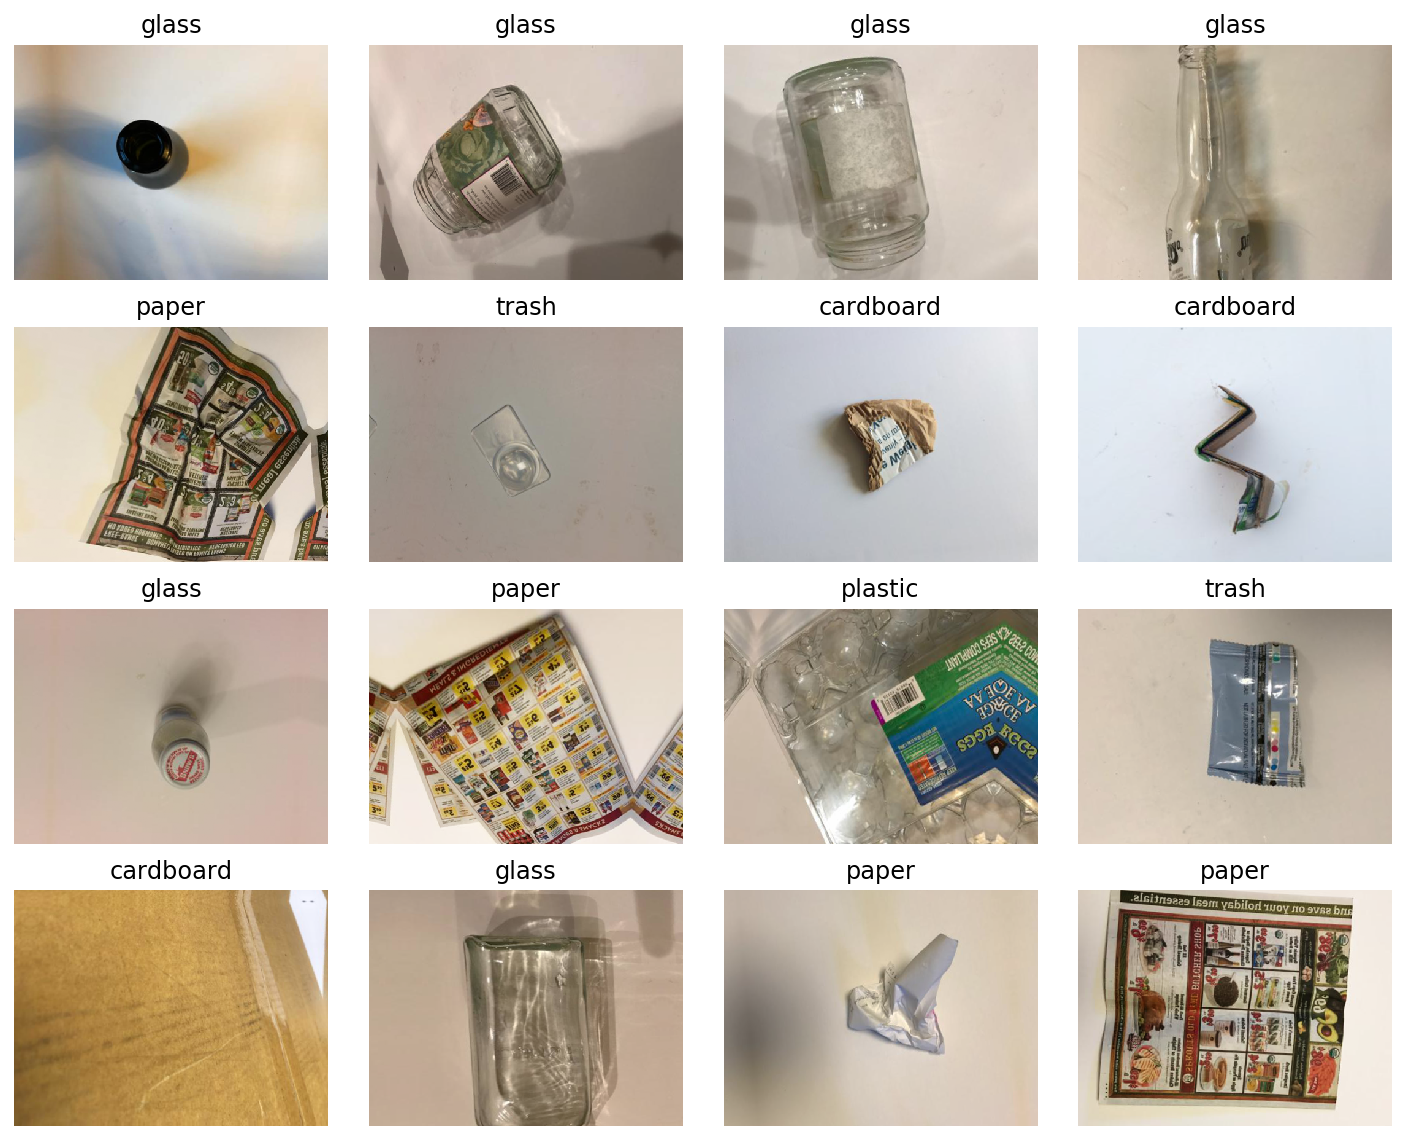

In [64]:
data.show_batch(rows = 4, figsize = (10, 8))

In [65]:
learn = create_cnn(data, models.densenet121, metrics = error_rate)
learn.model

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine

In [40]:
learn.lr_find(start_lr = 1e-6, end_lr = 1e1)
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

In [66]:
learn.fit_one_cycle(18, max_lr = 5.13e-03)

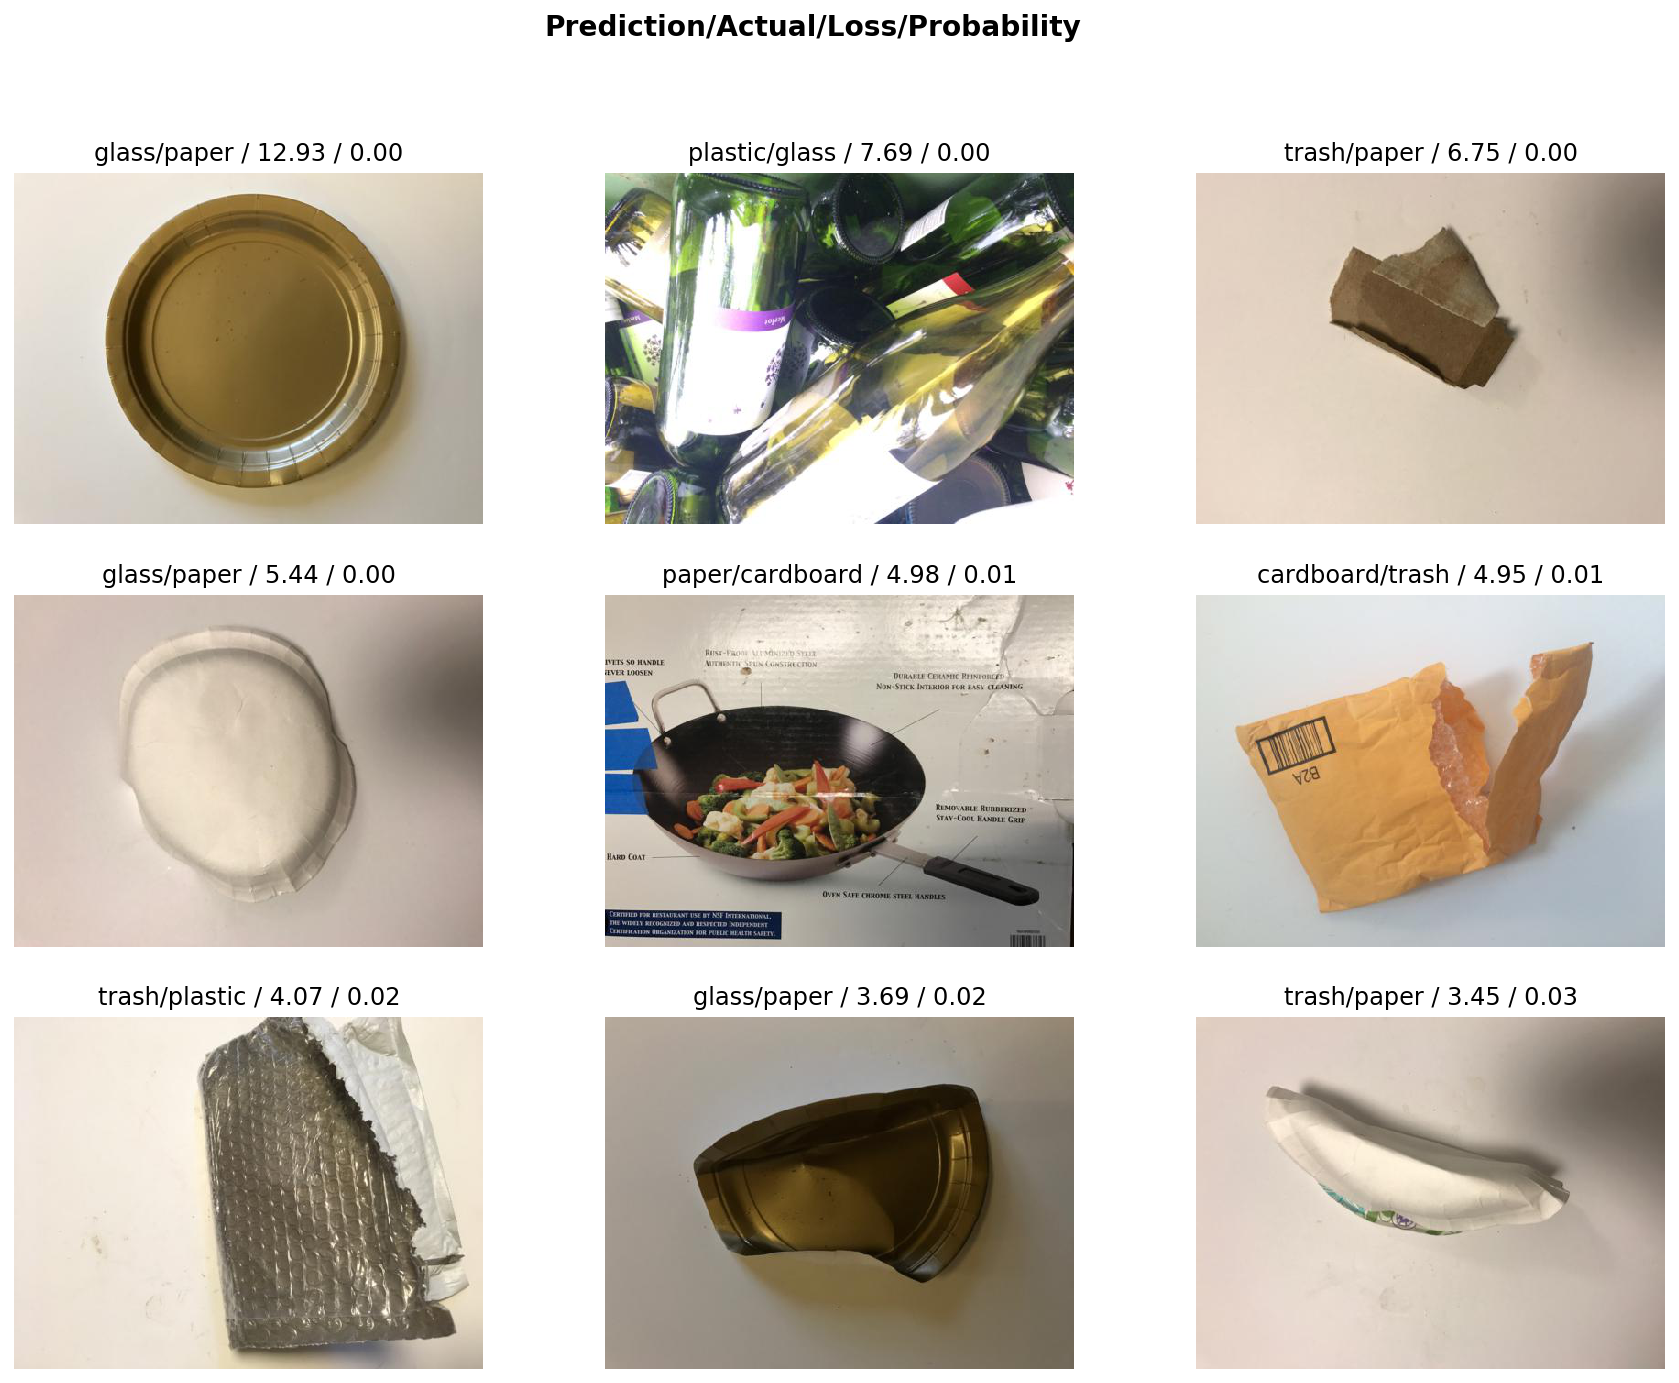

In [67]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
interp.plot_top_losses(9, figsize = (15, 11))

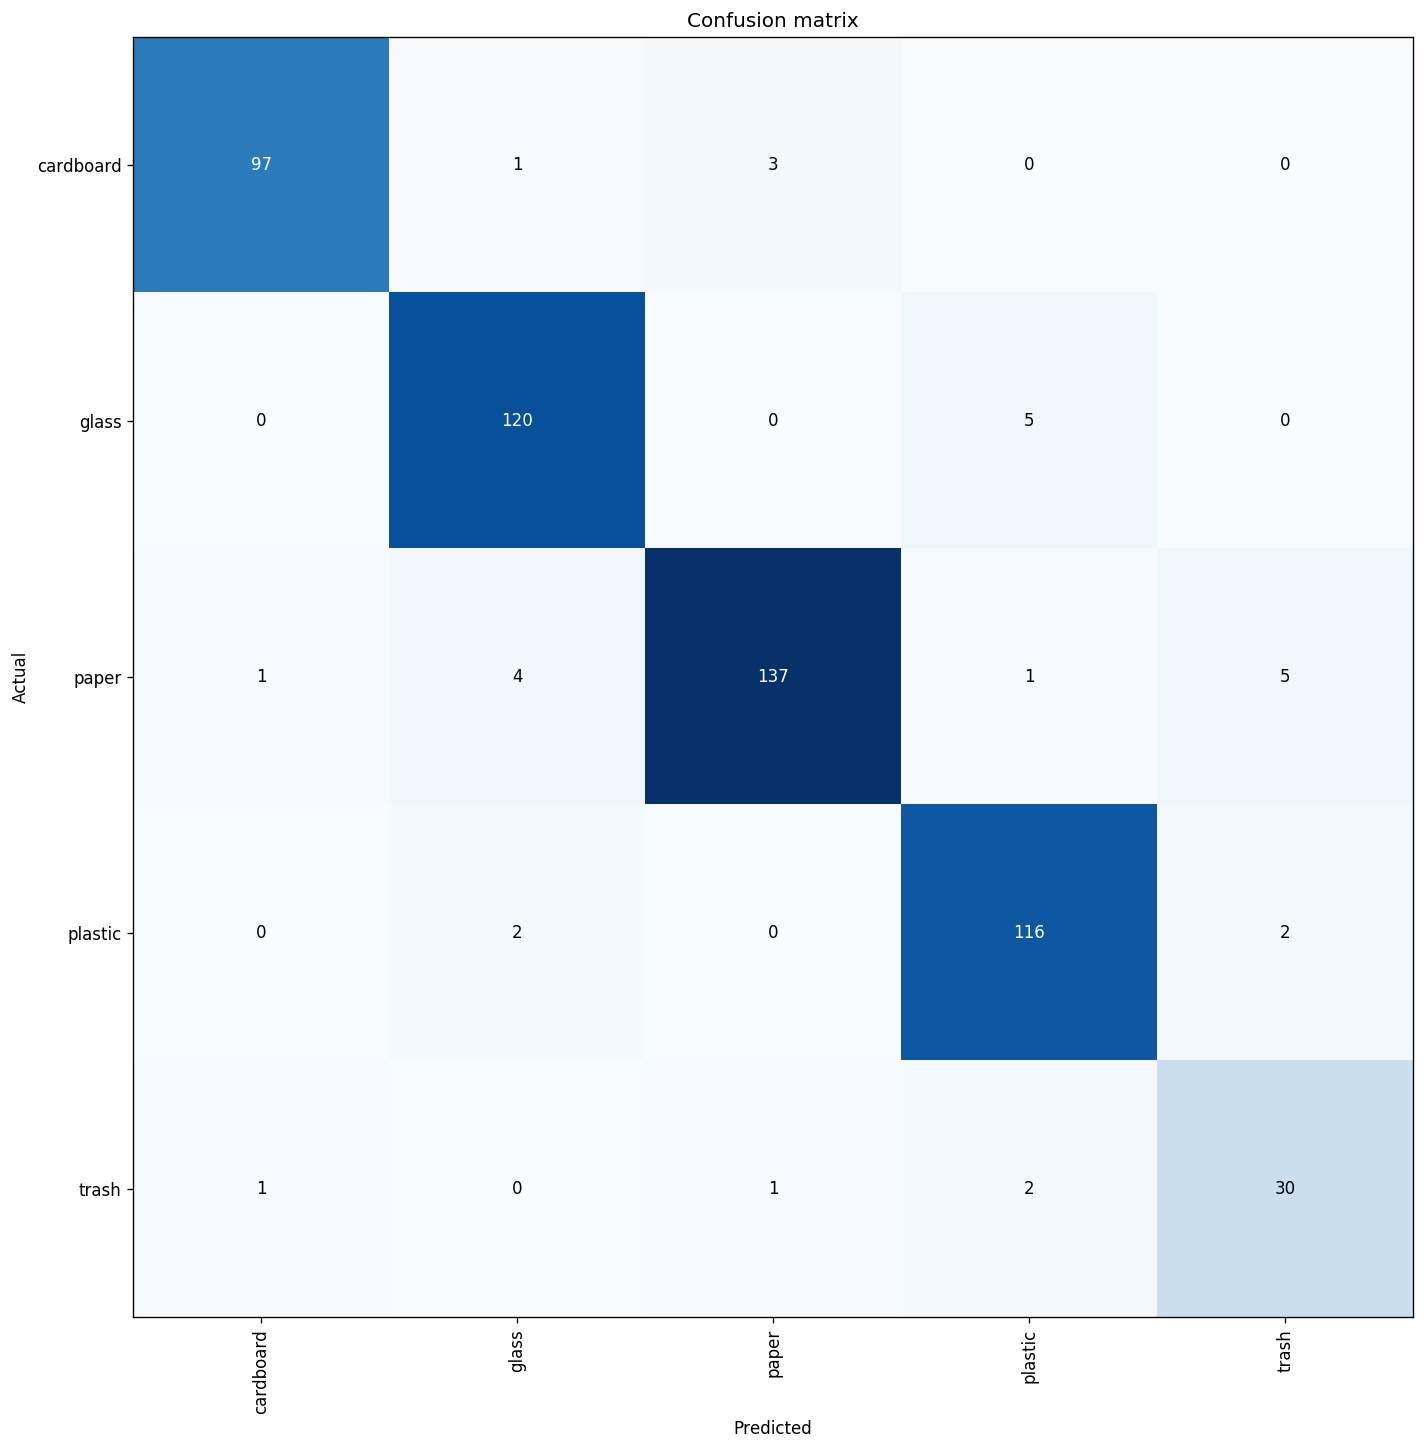

In [68]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize = (12, 12), dpi = 60)

In [69]:
interp.most_confused(min_val = 2)

[('glass', 'plastic', 5),
 ('paper', 'trash', 5),
 ('paper', 'glass', 4),
 ('cardboard', 'paper', 3),
 ('plastic', 'glass', 2),
 ('plastic', 'trash', 2),
 ('trash', 'plastic', 2)]

In [70]:
preds = learn.get_preds(ds_type = DatasetType.Test)
print(preds[0].shape)
preds[0]

torch.Size([532, 5])


tensor([[2.2142e-05, 3.9098e-08, 9.9998e-01, 1.4761e-07, 2.4428e-07],
        [6.2220e-07, 3.8041e-07, 1.1391e-08, 1.0000e+00, 2.3414e-06],
        [1.0408e-05, 3.3122e-01, 1.2178e-05, 6.6874e-01, 2.0553e-05],
        ...,
        [2.8944e-07, 2.5400e-05, 9.9927e-01, 6.9781e-04, 1.0098e-05],
        [1.2210e-05, 1.1527e-05, 1.8674e-07, 9.9997e-01, 5.9071e-06],
        [5.1186e-07, 1.0000e+00, 2.3451e-09, 1.2900e-06, 3.6671e-07]])

In [71]:
data.classes

['cardboard', 'glass', 'paper', 'plastic', 'trash']

In [72]:
max_idxs = np.asarray(np.argmax(preds[0], axis = 1))

yhat = []
for max_idx in max_idxs:
  yhat.append(data.classes[max_idx])

yhat

['paper',
 'plastic',
 'plastic',
 'cardboard',
 'plastic',
 'glass',
 'paper',
 'glass',
 'cardboard',
 'plastic',
 'cardboard',
 'paper',
 'plastic',
 'cardboard',
 'plastic',
 'cardboard',
 'paper',
 'paper',
 'cardboard',
 'paper',
 'glass',
 'cardboard',
 'cardboard',
 'paper',
 'cardboard',
 'glass',
 'glass',
 'glass',
 'plastic',
 'paper',
 'glass',
 'paper',
 'cardboard',
 'plastic',
 'paper',
 'paper',
 'paper',
 'glass',
 'trash',
 'paper',
 'plastic',
 'paper',
 'plastic',
 'cardboard',
 'cardboard',
 'paper',
 'paper',
 'cardboard',
 'glass',
 'paper',
 'paper',
 'glass',
 'plastic',
 'glass',
 'paper',
 'paper',
 'paper',
 'plastic',
 'paper',
 'glass',
 'paper',
 'plastic',
 'paper',
 'glass',
 'plastic',
 'plastic',
 'paper',
 'glass',
 'plastic',
 'glass',
 'cardboard',
 'plastic',
 'trash',
 'plastic',
 'glass',
 'glass',
 'paper',
 'paper',
 'glass',
 'paper',
 'cardboard',
 'paper',
 'cardboard',
 'paper',
 'paper',
 'trash',
 'cardboard',
 'paper',
 'glass',
 'plas

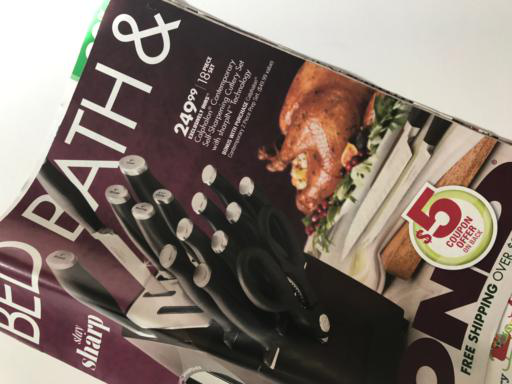

In [73]:
learn.data.test_ds[0][0]

In [74]:
y = []
for label_path in data.test_ds.items:
  y.append(str(label_path))

pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
  y[i] = pattern.search(y[i]).group(1)

print(yhat[0:5])
print(y[0:5])

['paper', 'plastic', 'plastic', 'cardboard', 'plastic']
['paper', 'plastic', 'glass', 'cardboard', 'plastic']


In [75]:
cm = confusion_matrix(y, yhat)
print(cm)

[[ 98   0   2   0   1]
 [  0 122   0   4   0]
 [  2   0 143   1   3]
 [  0   4   0 115   2]
 [  1   0   4   1  29]]


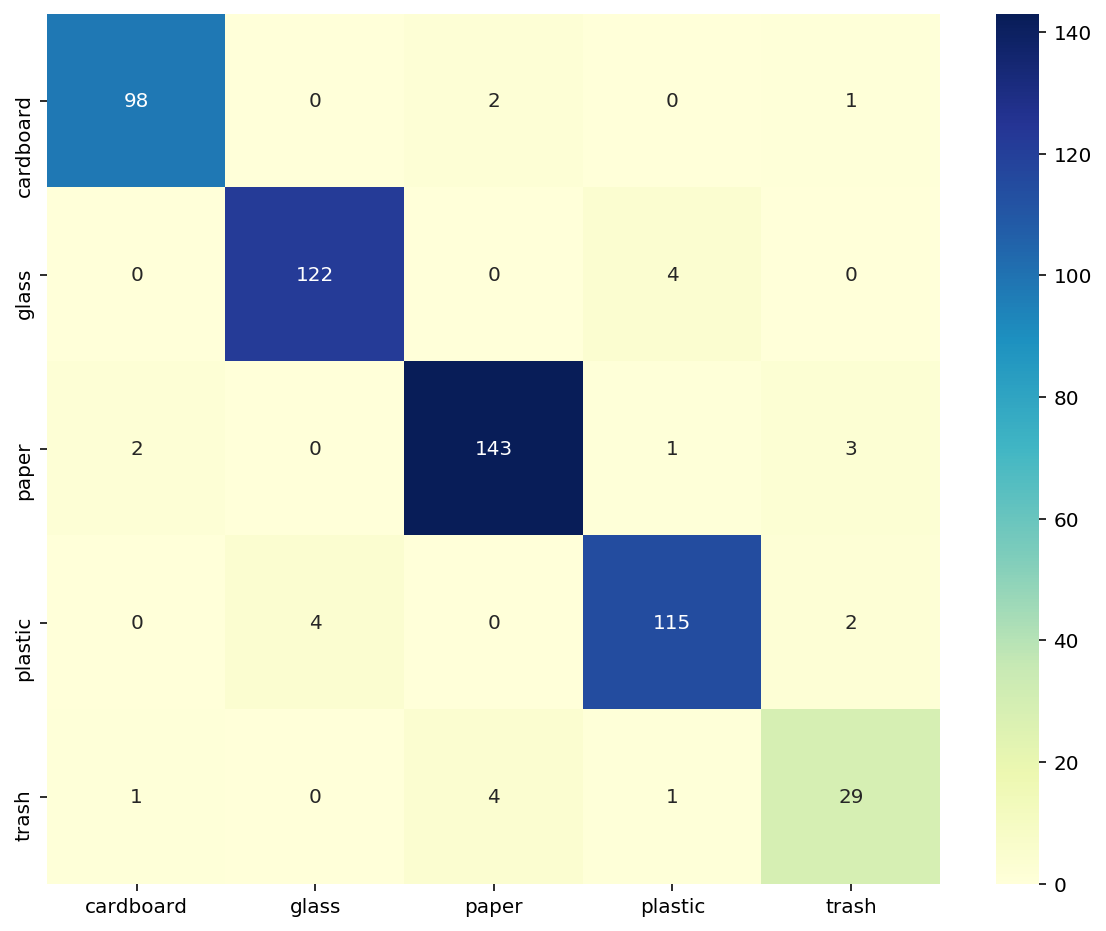

In [76]:
waste_types = ['cardboard', 'glass', 'paper', 'plastic', 'trash']
df_cm = pd.DataFrame(cm, waste_types, waste_types)

plt.figure(figsize = (10, 8))
sns.heatmap(df_cm, annot = True, fmt = "d", cmap = "YlGnBu")

In [77]:
correct = 0

for r in range(len(cm)):
  for c in range(len(cm)):
    if r == c:
      correct += cm[r, c]

accuracy = correct / sum(sum(cm))
accuracy

0.9530075187969925

In [0]:
learn.export()

In [9]:
learn_dn = create_cnn(data, models.densenet121, metrics = error_rate)
learn_dn.model

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


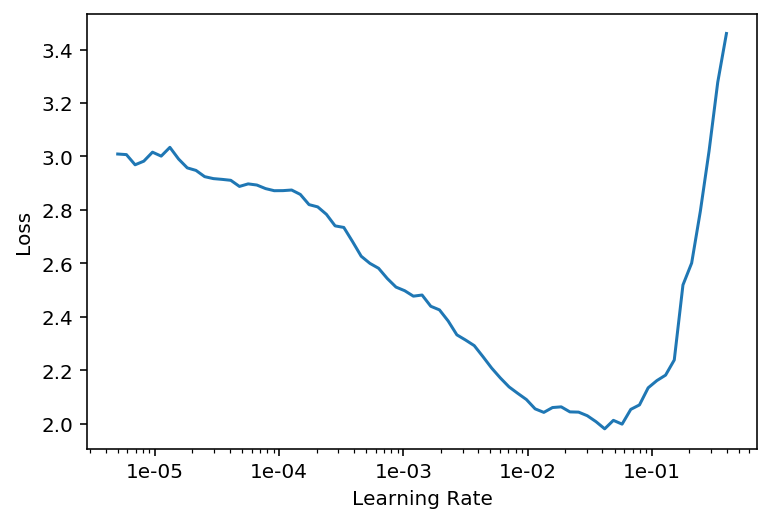

In [10]:
learn_dn.lr_find(start_lr = 1e-6, end_lr = 1e1)
learn_dn.recorder.plot()

In [12]:
learn_dn.fit_one_cycle(200, max_lr = 5.13e-03)

KeyboardInterrupt: ignored